In [273]:
import tensorflow as tf

In [280]:
# from util.input import inputs
import matplotlib.pylab as plt
%matplotlib inline

In [281]:
import os
import itertools
import tensorflow as tf
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import matplotlib.pyplot as plt

def make_pickle(imgs, img_names, type):
    img_label = {'images': imgs, 'labels': img_names}
    pickle.dump(img_label, open("data/%s.pkl" % type, "wb"))


def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def make_tfrecords(images, labels, type):

    num_examples = labels.shape[0]

    if images.shape[0] != num_examples:
        raise ValueError("Images size %d does not match label size %d." %
                         (images.shape[0], num_examples))
    rows = images.shape[1]
    cols = images.shape[2]
    depth = images.shape[3]

    directory = "."

    filename = os.path.join(directory, type + '.tfrecords')
    print('Writing', filename)
    writer = tf.python_io.TFRecordWriter(filename)
    for index in range(len(labels)):
        image_raw = images[index].tostring()
        example = tf.train.Example(features=tf.train.Features(feature={
            'height': _int64_feature(rows),
            'width': _int64_feature(cols),
            'depth': _int64_feature(depth),
            'label': _float_feature(float(labels[index])),
            'image_raw': _bytes_feature(image_raw)}))
        writer.write(example.SerializeToString())

In [282]:
CHANNEL = 3
HEIGHT = 60
WEIGHT = 80

In [283]:
def label0():
    return tf.constant(0)
def label1():
    return tf.constant(1)
def label2():
    return tf.constant(2)
def label3():
    return tf.constant(3)
def label4():
    return tf.constant(4)
def default():
    return tf.constant(-1)

In [284]:
def read_and_decode(filename_queue):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
        serialized_example,
        # Defaults are not specified since both keys are required.
        features={
            'image_raw': tf.FixedLenFeature([], tf.string),
            # 'angle': tf.FixedLenFeature([], tf.float32),
#             'label': tf.FixedLenFeature([], tf.int64),
            'label': tf.FixedLenFeature([], tf.float32),
#             'img_name': tf.FixedLenFeature([], tf.string)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.uint8)
#     img_name = tf.decode_raw(features['img_name'], tf.int64)
#



#     img_name = tf.cast(img_name, tf.int64)
#     img_name = None
    image.set_shape([HEIGHT * WEIGHT * CHANNEL])
    image = tf.cast(image, tf.float32) * (1. / 255) - 0.5
    image = tf.reshape(image, [HEIGHT, WEIGHT, CHANNEL])
    # image = tf.image.resize_images(image, tf.pack(tf.constant(60, dtype=tf.int32), tf.constant(80, dtype=tf.int32)))
    
    # preprocessing
    # image = tf.image.rgb_to_grayscale(image)
    # image = tf.image.per_image_standardization(image)
    # image = tf.image.per_image_whitening(image)

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    angle = tf.cast(features['label'], tf.float32)


    label = tf.cond(tf.less(angle, tf.constant(-0.03966)), label0,
            lambda: tf.cond(tf.less(angle, tf.constant(-0.00698)), label1,
                            lambda: tf.cond(tf.less(angle, tf.constant(0.01266)), label2,
                                            lambda: tf.cond(tf.less(angle, tf.constant(0.04189)), label3, label4))))

    angle = tf.reshape(angle, [1])
    img_name = None
#     label = None
#     angle = None

    # label = None
    # label = tf.cond(tf.equal(label, 0), lambda: tf.convert_to_tensor(0), lambda: tf.convert_to_tensor(1))

    return image, angle, label, img_name

In [285]:
TRAIN_DIR = "data"

In [322]:
def aggregate_dataset(direction, dataset, label, dataset_subset='all'):

    """
        direction = ['left', 'center', 'right']
        dataset = ['original', 'flip', 'contrast', 'flip_contrast']
        label = [0]
        dataset_subset = 'all' or ['train','val']

        return {}
    """
    train_lst = []
    test_lst = []
    validation_lst = []

    def get_subset_lst(subset):
        subste_list = []
        for a, b in list(itertools.product(direction, dataset)):
            folders = [folder for folder in os.listdir(TRAIN_DIR) if folder.startswith("udacity")]
            for folder in folders:

                try:
                    dir = TRAIN_DIR + "/" + folder + "/%s/%s/label%s" % (a, b, label)
                    print(dir)
#                     print(os.listdir("./"+dir))
                    train = [dir + "/" + file for file in os.listdir(dir) if subset in file]
                    print(train)
                    subste_list += train
                except:
                    pass
        return [subset, subste_list]

    train_lst = np.array(train_lst)
    test_lst = np.array(test_lst)
    validation_lst = np.array(validation_lst)

    if dataset_subset is 'all':
        dataset_subset = ['train', 'test', 'validation']

    total_dict = {}
    for subset in dataset_subset:
        total_dict[get_subset_lst(subset)[0]] = get_subset_lst(subset)[1]

    return total_dict

In [323]:
aggregate_dataset(['center'], ['original'], 0, ['test'])

data/udacity-dataset-2/center/original/label0
data/udacity-dataset-2/center/original/label0


{'test': []}

In [167]:

filename = aggregate_dataset(['center'], ['contrast'], ['train'])['train']
filename = ["data/train.tfrecords", "data/test.tfrecords", "data/submission_test.tfrecords"]

In [143]:
filename

['data/train.tfrecords',
 'data/test.tfrecords',
 'data/submission_test.tfrecords']

In [144]:
# number of observations in training
idx = 0
for fn in filename:
    print(fn)
    for record in tf.python_io.tf_record_iterator(fn):
        idx += 1
    print(idx)
    idx = 0



data/train.tfrecords
49079
data/test.tfrecords
10827
data/submission_test.tfrecords
6601


In [101]:
num_epochs = None
batch_size = 100
with tf.name_scope('input'):
    filename_queue = tf.train.string_input_producer(
        filename, num_epochs=num_epochs)

    image, angle, label, img_name = read_and_decode(filename_queue)
    images = []
    angles = []
    labels = []
    with tf.Session() as sess:
        # Start populating the filename queue.
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        for i in range(49079):
            # Retrieve a single instance:
            img, ang, lab = sess.run([image, angle, label])
            images.append(img)
            angles.append(ang)
            labels.append(lab)
        coord.request_stop()
        coord.join(threads)
        print('done!!')

done!!


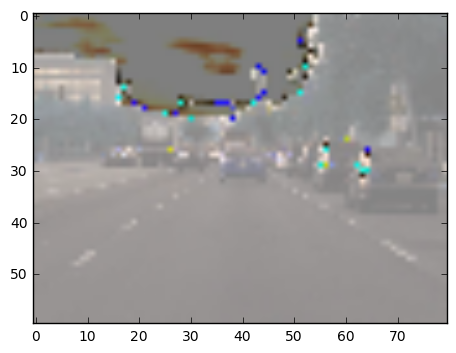

In [137]:
plt.imshow(images[12572])

In [139]:
np.max(angles, )

0.27440768

In [140]:
0.27440768 * 180 / np.pi

15.72240192997645

In [85]:
ang

array([ 0.01745329], dtype=float32)

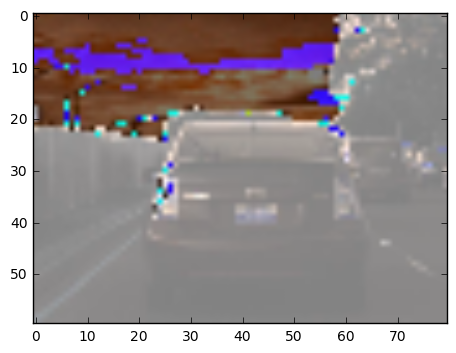

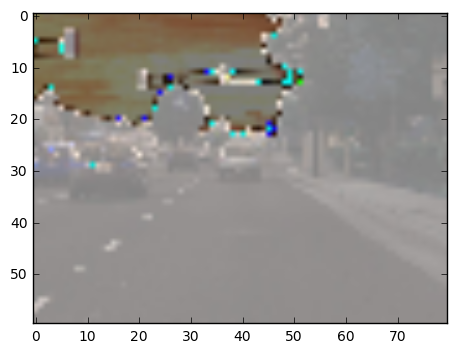

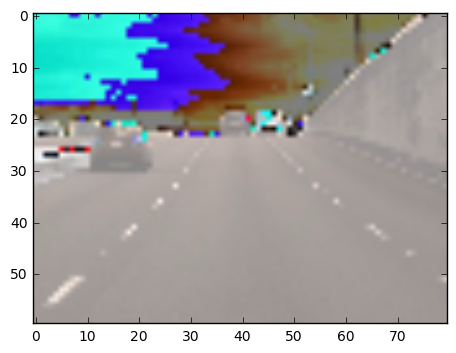

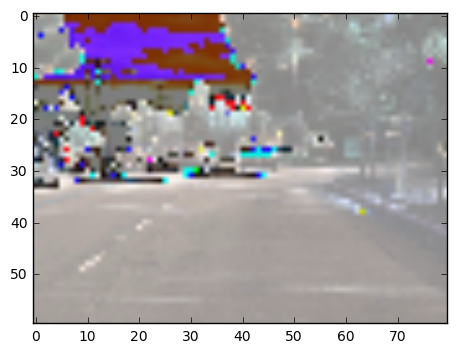

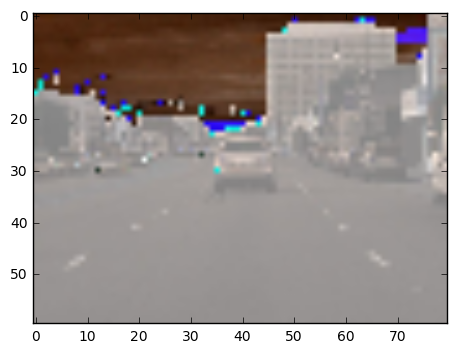

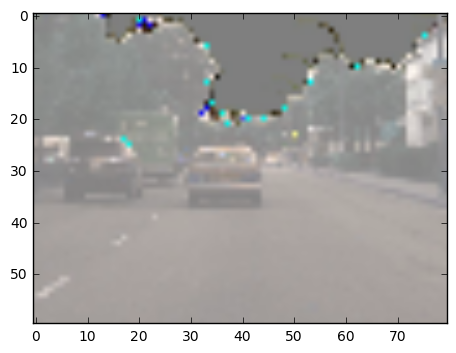

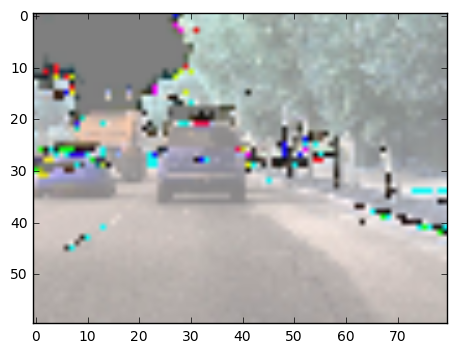

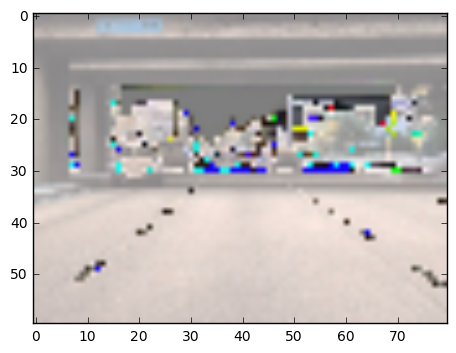

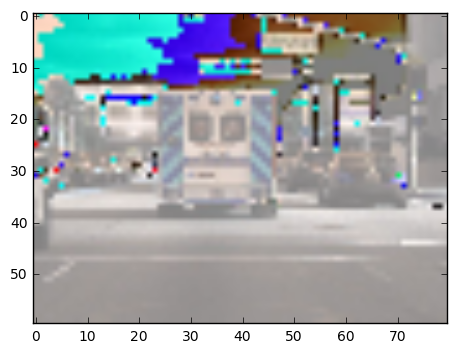

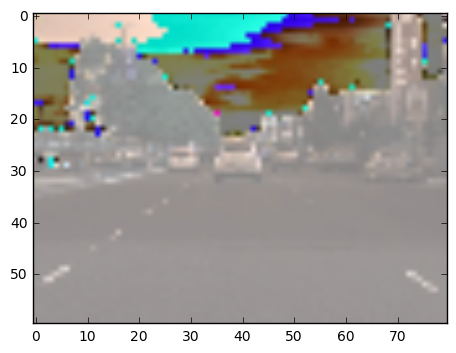

In [142]:
for i in range(10):
    plt.imshow(images[i])
    plt.figure()

In [47]:
tmp[1:10]

[array([1477439597173798880]),
 array([1477439717240636315]),
 array([1477439614826225472]),
 array([1477439556718102526]),
 array([1477439727642341252]),
 array([1477439612825925725]),
 array([1477439613526155492]),
 array([1477439662332895974]),
 array([1477439493959199967])]

In [105]:
plt.imshow(img_names[999])

IndexError: list index out of range

In [47]:
np.concatenate(img_names)

array([-0.00872665,  0.00174533, -0.0106064 , -0.01047198, -0.00174533,
       -0.00174533,  0.04837419, -0.03490658,  0.02443461,  0.00375849,
        0.01472643,  0.00022914,  0.12566371, -0.01396263,  0.05078869,
       -0.01570796,  0.03675999,  0.03316126, -0.01047198,  0.04184481,
       -0.01491667, -0.04686459, -0.04537856, -0.071329  , -0.03141593,
        0.05811516,  0.037611  ,  0.01047198, -0.01396263,  0.08028515,
        0.01964896, -0.01912297, -0.00174533, -0.00729858, -0.01919862,
        0.07200993,  0.07330383,  0.02792527, -0.02268928, -0.02792527,
       -0.02094395,  0.00872665, -0.00523599,  0.07412998, -0.00375505,
       -0.03316126, -0.09250245,  0.01396263,  0.01896811,  0.0648128 ,
       -0.00174533,  0.0175952 , -0.00537863,  0.05149613, -0.01460221,
       -0.00349066, -0.00698132, -0.02268928,  0.00698132,  0.00872665,
       -0.06766396, -0.01745329,  0.00174533,  0.0346966 , -0.00872665,
        0.00872665, -0.00140603, -0.06283186, -0.01919862,  0.00

In [20]:
filenames = aggregate_dataset(['center'], ['original'], ['train'])['train']

In [21]:
filenames

['data/udacity-dataset-2/center/original/train_0.tfrecords']

In [22]:
num_epochs = None
batch_size = 100
one_hot_labels = False
with tf.name_scope('input'):
    filename_queue = tf.train.string_input_producer(
        filenames, num_epochs=num_epochs)

    image, angle, label, img_name = read_and_decode(filename_queue)
    if one_hot_labels:
        print("one_hot_labels")
        label = tf.one_hot(label, NUM_CLASSES, dtype=tf.int32)
        images, sparse_labels = tf.train.shuffle_batch(
            [image, label], batch_size=batch_size, num_threads=4,
            capacity=1000 + 3 * batch_size,
            # Ensures a minimum amount of shuffling of examples.
            min_after_dequeue=1000)
#         return images, sparse_labels
    else:
        pass

In [23]:
images, sparse_angles = tf.train.shuffle_batch(
                        [image, angle], batch_size=batch_size, num_threads=4,
                        capacity=1000 + 3 * batch_size,
                        # Ensures a minimum amount of shuffling of examples.
                        min_after_dequeue=1000)

In [30]:
images = []
angles = []

num_epochs = None
batch_size = 100
one_hot_labels = False
with tf.name_scope('input'):
    filename_queue = tf.train.string_input_producer(
        filenames, num_epochs=num_epochs)

    image, angle, label, img_name = read_and_decode(filename_queue)
    if one_hot_labels:
        print("one_hot_labels")
        label = tf.one_hot(label, NUM_CLASSES, dtype=tf.int32)
        images, sparse_labels = tf.train.shuffle_batch(
            [image, label], batch_size=batch_size, num_threads=4,
            capacity=1000 + 3 * batch_size,
            # Ensures a minimum amount of shuffling of examples.
            min_after_dequeue=1000)
#         return images, sparse_labels
    else:
        print('here')
        with tf.Session() as sess:
            # Start populating the filename queue.
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(coord=coord)

        #     images, sparse_angles = tf.train.shuffle_batch(
        #         [image, angle], batch_size=batch_size, num_threads=4,
        #         capacity=1000 + 3 * batch_size,
        #         # Ensures a minimum amount of shuffling of examples.
        #         min_after_dequeue=1000)

            for i in range(batch_size):
                # Retrieve a single instance:
                img = sess.run([image])
                print(img)
        #         if label == 0:

        #             if angle < -0.03966:
        #                 images.append(img)
        #                 angles.append(ang)
        #         elif label == 1:
        #             if -0.03966 <= ang and ang < -0.00698:
        #                 images.append(img)
        #                 angles.append(ang)
        #         elif label == 2:
        #             if -0.00698 <= ang and ang < 0.01266:
        #                 images.append(img)
        #                 angles.append(ang)
        #         elif label == 3:
        #             if 0.01266 <= ang and ang < 0.04189:
        #                 images.append(img)
        #                 angles.append(ang)
        #         elif label == 4:
        #             if 0.04189 <= ang:
        #                 images.append(img)
        #                 angles.append(ang)

            coord.request_stop()
            coord.join(threads)

here


InvalidArgumentError: Name: <unknown>, Feature: label.  Data types don't match. Data type: int64Expected type: float
	 [[Node: input_5/ParseSingleExample/ParseExample/ParseExample = ParseExample[Ndense=2, Nsparse=0, Tdense=[DT_STRING, DT_FLOAT], dense_shapes=[[], []], sparse_types=[], _device="/job:localhost/replica:0/task:0/cpu:0"](input_5/ParseSingleExample/ExpandDims, input_5/ParseSingleExample/ParseExample/ParseExample/names, input_5/ParseSingleExample/ParseExample/ParseExample/dense_keys_0, input_5/ParseSingleExample/ParseExample/ParseExample/dense_keys_1, input_5/ParseSingleExample/ParseExample/Const, input_5/ParseSingleExample/ParseExample/Const_1)]]

Caused by op 'input_5/ParseSingleExample/ParseExample/ParseExample', defined at:
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-a45425d69b0b>", line 11, in <module>
    image, angle, label, img_name = read_and_decode(filename_queue)
  File "/Users/daniel/Dropbox/udacity_challenge2_v2/util/input.py", line 51, in read_and_decode
    'label': tf.FixedLenFeature([], tf.float32),
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/tensorflow/python/ops/parsing_ops.py", line 453, in parse_single_example
    dense_types, dense_defaults, dense_shapes, name)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/tensorflow/python/ops/parsing_ops.py", line 525, in _parse_single_example_raw
    name=name)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/tensorflow/python/ops/parsing_ops.py", line 405, in _parse_example_raw
    name=name)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/tensorflow/python/ops/gen_parsing_ops.py", line 165, in _parse_example
    dense_shapes=dense_shapes, name=name)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/daniel/anaconda3/envs/tensorflow2/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Name: <unknown>, Feature: label.  Data types don't match. Data type: int64Expected type: float
	 [[Node: input_5/ParseSingleExample/ParseExample/ParseExample = ParseExample[Ndense=2, Nsparse=0, Tdense=[DT_STRING, DT_FLOAT], dense_shapes=[[], []], sparse_types=[], _device="/job:localhost/replica:0/task:0/cpu:0"](input_5/ParseSingleExample/ExpandDims, input_5/ParseSingleExample/ParseExample/ParseExample/names, input_5/ParseSingleExample/ParseExample/ParseExample/dense_keys_0, input_5/ParseSingleExample/ParseExample/ParseExample/dense_keys_1, input_5/ParseSingleExample/ParseExample/Const, input_5/ParseSingleExample/ParseExample/Const_1)]]


In [18]:
images

<tf.Tensor 'shuffle_batch:0' shape=(100, 60, 80, 3) dtype=float32>

In [7]:
image, angle, label, img_name = read_and_decode(filename_queue)

NameError: name 'filename_queue' is not defined

In [ ]:
images, angles = inputs(train_dir, True, batch_size, num_batches, label, one_hot_labels=False)   